# 6.1 参数的更新

## 6.1.2 SGD

SGD的python类

In [1]:
class SGD:

    def __init__(self, lr = 0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

# 使用该SGD类，可以按如下方式进行神经网络的参数的更新（以下是伪代码）
network = TwoLayerNet(...)
#! 进行最优化的类(SGD, momentum等)
optimizer = SGD()

for i in range(10000):
    ...
    # mini-batch
    x_batch, t_batch = get_mini_batch(...)
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    #! 执行具体优化
    optimizer.update(params, grads)
    ...

## 6.1.4 Momentum

In [2]:
# common/optimizer.py
import numpy as np

class Momentum:

    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):

        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

## 6.1.5 AdaGrad

In [3]:
# common/optimizer.py
class AdaGrad:

    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None
    
    def updates(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            # 1e-7: 防止0作除数
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

## 6.1.6 Adam

见common/optimizer.py

## 6.1.7 使用哪种更新方法呢？

ch06/optimizer_compare_naive.py

实例：$f(x, y)=\frac{1}{20}x^2+y^2$

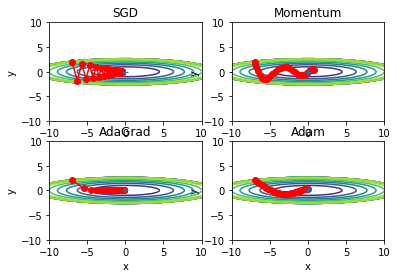

In [5]:
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *

# 实例函数
def f(x, y):
    return x**2 / 20.0 + y**2

# 函数梯度
def df(x, y):
    return x / 10.0, 2.0*y

# 起始点
init_pos = (-7.0, 2.0)

params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

# 子图索引
idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):

        # 记录路径
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        # df是实例函数的梯度
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

## 6.1.8 基于MNIST数据集的更新方法的比较

ch06/optimizer_compare_mnist.py

===========iteration:0===========
SGD:2.521011408830584
Momentum:2.3677412573967116
AdaGrad:2.4137866998709394
Adam:2.268837900043106
===========iteration:100===========
SGD:1.3411527035905486
Momentum:0.35736615714313325
AdaGrad:0.13257359221421722
Adam:0.19626268300149885
===========iteration:200===========
SGD:0.7262643280185127
Momentum:0.21528046035477671
AdaGrad:0.056194841815271665
Adam:0.125629689544493
===========iteration:300===========
SGD:0.473291174999428
Momentum:0.10152641910989907
AdaGrad:0.04118220461355572
Adam:0.07962410023152944
===========iteration:400===========
SGD:0.4341910230360976
Momentum:0.18431226828793446
AdaGrad:0.10647923106947364
Adam:0.13425004828829484
===========iteration:500===========
SGD:0.39869877147217486
Momentum:0.19071643623404855
AdaGrad:0.09087789000099732
Adam:0.12071682608401632
===========iteration:600===========
SGD:0.32765278160454975
Momentum:0.10817515434285879
AdaGrad:0.06394422916721859
Adam:0.07306249500807116
===========iteration

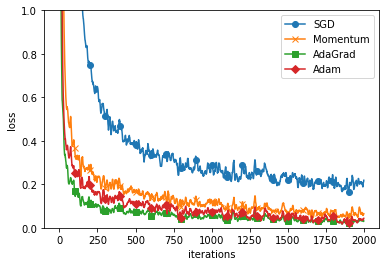

In [6]:
import os
import sys
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0:读入MNIST数据==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:进行实验的设置==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}

for key in optimizers.keys():
    # 5层神经网络，每层有100个神经元， 激活函数ReLU
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:开始训练==========

# 循环次数
for i in range(max_iterations):

    # mini-batch
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 更新每种优化器
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.绘制图形==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()